In [ ]:
"""
Script for reading in WRF met_em files and editing every variable

Ideally, for this we will utilize the mean soundign from either Jordan or Dunian et al. 2011 to create a 3-D
Homogenous envionment. First, we will do this for one met_em file, then, we will utilze this same technique for 
every met_em file in our directory, thus meaning we will need to create a loop to do this! 

Some interesting things to consider here:
    1. Must adjust elevation and land mask so that we create only as ocean domain first
        1a. Change SST's + skin temperature of the ocean
        1b. Must make it homogenous throughout the domain, we can add a gradient if we like to be realistic but 
            in the deep summer month of August, there isn't much of a gradient N/S, especially in the western Atlantic
    
    2 . Once we adress the ocean, we then need to adress the Atmosphere! 
        2a. Input the Dunian et al. 2011 sounding and extrapolate/interpolate to the 50 levels we have in our modeled 
            atmosphere
        2b. We then make this profile of our whole atmosphere
"""

In [5]:
#import packages
import xarray as xr
import numpy as np
import glob
import matplotlib.pyplot as plt
import cv2

#for Some Pertinent Meteorological Calculations
import metpy.interpolate
from metpy.calc import wind_components
from metpy.units import units

In [6]:
file_path = "/Users/cjmasiel/Desktop/met_em.d01.2007-08-18_00:00:00.nc"   #path to met_em file
new_file_path = "/Users/cjmasiel/Desktop/New_met_em/"                     #Output directory

In [7]:
file = xr.open_dataset(file_path)
file

<xarray.Dataset>
Dimensions:      (Time: 1, num_metgrid_levels: 38, south_north: 340, west_east: 616, num_st_layers: 4, num_sm_layers: 4, south_north_stag: 341, west_east_stag: 617, z-dimension0012: 12, z-dimension0016: 16, z-dimension0021: 21)
Dimensions without coordinates: Time, num_metgrid_levels, south_north, west_east, num_st_layers, num_sm_layers, south_north_stag, west_east_stag, z-dimension0012, z-dimension0016, z-dimension0021
Data variables: (12/79)
    Times        (Time) |S19 ...
    PRES         (Time, num_metgrid_levels, south_north, west_east) float32 ...
    SOIL_LAYERS  (Time, num_st_layers, south_north, west_east) float32 ...
    SM           (Time, num_sm_layers, south_north, west_east) float32 ...
    ST           (Time, num_st_layers, south_north, west_east) float32 ...
    GHT          (Time, num_metgrid_levels, south_north, west_east) float32 ...
    ...           ...
    XLONG_U      (Time, south_north, west_east_stag) float32 ...
    XLAT_U       (Time, south_north, west_east_stag) float32 ...
    XLONG_V      (Time, south_north_stag, west_east) float32 ...
    XLAT_V       (Time, south_north_stag, west_east) float32 ...
    XLONG_M      (Time, south_north, west_east) float32 ...
    XLAT_M       (Time, south_north, west_east) float32 ...
Attributes: (12/116)
    TITLE:                           OUTPUT FROM METGRID V4.4
    SIMULATION_START_DATE:           2007-08-18_00:00:00
    WEST-EAST_GRID_DIMENSION:        617
    SOUTH-NORTH_GRID_DIMENSION:      341
    BOTTOM-TOP_GRID_DIMENSION:       38
    WEST-EAST_PATCH_START_UNSTAG:    1
    ...                              ...
    FLAG_VAR_SSO:                    1
    FLAG_LAKE_DEPTH:                 1
    FLAG_IMPERV:                     1
    FLAG_CANFRA:                     1
    FLAG_CLAYFRAC:                   1
    FLAG_SANDFRAC:                   1

Domain Size S_N: 340
Domain Size W_E: 616
<xarray.DataArray 'LANDSEA' (Time: 1, south_north: 340, west_east: 616)>
array([[[0., 0., ..., 1., 1.],
        [0., 0., ..., 1., 1.],
        ...,
        [0., 0., ..., 1., 1.],
        [0., 0., ..., 1., 1.]]], dtype=float32)
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    units:        0/1 Flag
    description:  Land/Sea flag
    stagger:      M
    sr_x:         1
    sr_y:         1
(1, 16, 340, 616)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
Done with geographical information
Done with SST information
pressure Stuff: 101480.0
pressure Stuff: 100000.0
pressure Stuff: 97500.0
pressure Stuff: 95000.0
pressure Stuff: 92500.0
pressure Stuff: 90000.0
pressure Stuff: 87500.0
pressure Stuff: 85000.0
pressure Stuff: 82500.0
pressure Stuff: 80000.0
pressure Stuff: 77500.0
pressure Stuff: 75000.0
pressure Stuff: 70000.0
pressure Stuff: 65000.0
pressure Stuff: 60000.0
pressure Stuff: 

/Users/cjmasiel/opt/anaconda3/lib/python3.9/site-packages/metpy/interpolate/one_dimension.py:152: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')


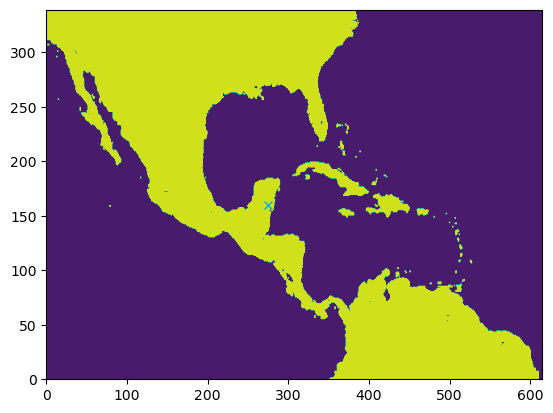

In [8]:
with xr.open_dataset(file_path) as ds:
    file_name = 'adjusted_met_em.d01.2007-08-18_00:00:00.nc'             #You'll have to edit this: getting just the filename, cutting off the rest of the path
    
    landmask_old = ds['LANDMASK'][:,:,:]    #This is our landmask variable
    landmask = ds['LANDMASK'][:,:,:]        #this is the array we will adjsut
    
    landsea_old = ds['LANDSEA'][:,:,:]
    landsea = ds['LANDSEA'][:,:,:]
  
    print("Domain Size S_N:", len(landmask[0,:,0]))
    print("Domain Size W_E:", len(landmask[0,0,:]))
    
    S_N = len(landmask[0,:,0])
    W_E = len(landmask[0,0,:])

    for i in range(0,S_N):           #y coords (range)
        for j in range(0,W_E):       #x coords (range)
            x = 200                  #Vertical Line at the 200
            landmask[:,i,j]=0
            landsea[:,i,j]=0
            if j < x:
                landmask[:,i,j]=1
                landsea[:,i,j]=1
    
    ds['LANDMASK'][:,:,:] = landmask  #Overwrite landmask data
    ds['LANDSEA'][:,:,:] = landsea    #Overwrite landmask data
    
    #Now that we have overwritten and created a new landsea and landmask, we want to invert the landsea mask for SST
    #Calculations
    
    landsea_inverted = landsea
    
    for i in range(0,S_N):                       #y coords (range)
        for j in range(0,W_E):                   #x coords (range)
            if landsea_inverted[0,i,j] == 1.:
                landsea_inverted[0,i,j] = 0.
            elif landsea_inverted[0,i,j] == 0.:
                landsea_inverted[0,i,j] = 1.
    
    print(landsea_inverted)
    
    #Now that we have the landmask of interest, we need to spcecify vegetation type and all the other pertinent land 
    #Use variables, Morgan did this, but we will adjust it for our purposes.
    
    #Specify a specific location that we are interested in for homoginizing our domain, Specifically we are chosing a
    #Location in the Yucatan, but we can change this later on to a location we are interested in!
    S_N_landpoint = 160 
    W_E_landpoint = 275 
    
    #Quick check in the loop to make sure the point we are choosing actually is the point we want:
    plt.contourf(landmask_old[0,:,:])       #Old landmask
    plt.plot(W_E_landpoint, S_N_landpoint, "x", color = '#00B2EE', label = "Location of interest")

    #2d variables
    ##canfrac  = ds['CANFRA'][:,S_N_landpoint,W_E_landpoint]      #canopy fraction, no data outside US
    clayfrac = ds['CLAYFRAC'][:,S_N_landpoint,W_E_landpoint]    #clay fraction 
    con      = ds['CON'][:,S_N_landpoint,W_E_landpoint]         #tbd
    ##imprev   = ds['IMPERV'][:,S_N_landpoint,W_E_landpoint]      #imperviousness percent, no data outside US
    lakdep   = ds['LAKE_DEPTH'][:,S_N_landpoint,W_E_landpoint]  #lake depth mostly just the great lakes 
    luinx    = ds['LU_INDEX'][:,S_N_landpoint,W_E_landpoint]    #land use index 
    oa1      = ds['OA1'][:,S_N_landpoint,W_E_landpoint]         #OA 1 variable (no idea what it is)
    oa2      = ds['OA2'][:,S_N_landpoint,W_E_landpoint]         #OA 2 variable (no idea what it is)
    oa3      = ds['OA3'][:,S_N_landpoint,W_E_landpoint]         #OA 3 variable (no idea what it is)
    oa4      = ds['OA4'][:,S_N_landpoint,W_E_landpoint]         #OA 4 variable (no idea what it is)
    ol1      = ds['OL1'][:,S_N_landpoint,W_E_landpoint]         #OL 1 variable (no idea what it is) 
    ol2      = ds['OL2'][:,S_N_landpoint,W_E_landpoint]         #OL 2 variable (no idea what it is) 
    ol3      = ds['OL3'][:,S_N_landpoint,W_E_landpoint]         #OL 3 variable (no idea what it is)
    ol4      = ds['OL4'][:,S_N_landpoint,W_E_landpoint]         #OL 4 variable (no idea what it is) 
    sandfrac = ds['SANDFRAC'][:,S_N_landpoint,W_E_landpoint]    #sandfraction
    scb_dom  = ds['SCB_DOM'][:,S_N_landpoint,W_E_landpoint]     #soil dom category
    sct_dom  = ds['SCT_DOM'][:,S_N_landpoint,W_E_landpoint]     #soil category
    
    #Now we have all the soil moisture stuff
    SM1      = ds['SM000007'][:,S_N_landpoint,W_E_landpoint]   
    SM2      = ds['SM007028'][:,S_N_landpoint,W_E_landpoint]
    SM3      = ds['SM028100'][:,S_N_landpoint,W_E_landpoint]
    SM4      = ds['SM100289'][:,S_N_landpoint,W_E_landpoint]
    ST1      = ds['ST000007'][:,S_N_landpoint,W_E_landpoint]
    ST2      = ds['ST007028'][:,S_N_landpoint,W_E_landpoint]
    ST3      = ds['ST028100'][:,S_N_landpoint,W_E_landpoint]
    ST4      = ds['ST100289'][:,S_N_landpoint,W_E_landpoint]
  
    snoalb   = ds['SNOALB'][:,S_N_landpoint,W_E_landpoint]      #maximum snow albedo
    soiltemp = ds['SOILTEMP'][:,S_N_landpoint,W_E_landpoint]    #soil temp
    hgt = 1                                                     #Height we are specifying for our land! 1m in our case
    var      = ds['VAR'][:,S_N_landpoint,W_E_landpoint]         #no idea what var is
    varsso   = ds['VAR_SSO'][:,S_N_landpoint,W_E_landpoint]     #again, no idea what varsso is, we are changing it though
    

    # 3d variables, choose your month (1-12) example August == 7 since January = 0, December == 11
    alb12    = ds['ALBEDO12M'][:,7,S_N_landpoint,W_E_landpoint]     #3d albedo by month
    grenfrac = ds['GREENFRAC'][:,7,S_N_landpoint,W_E_landpoint]     #greenfraction 
    lai12m   = ds['LAI12M'][:,7,S_N_landpoint,W_E_landpoint] 

    # 3d Varibles with categories 
    # k is the number of categories (ncview variable to find out)
    # Must do this through loop 
    
    #first, let's zero out our arrays
    landuse = ds['LANDUSEF'][:,:,:,:] * 0
    
    for k in range(21):                                             #Max levels = 21 for landuse, or 22 levels 
        landuse_value = ds['LANDUSEF'][:,k,S_N_landpoint,W_E_landpoint]   #3d landuse for a specific location, 
        if k == 16:
            landuse[:,k,:,:] = landsea_inverted
            ds['LANDUSEF'][:,k,:,:] = landuse[:,k,:,:]
        if k != 16:
            landuse[:,k,:,:] = landuse_value * landmask
            ds['LANDUSEF'][:,k,:,:] = landuse[:,k,:,:]
    
    #let's zero out the arrays:
    soilbot = ds['SOILCBOT'][:,:,:,:] * 0 
    soiltop = ds['SOILCTOP'][:,:,:,:] * 0
    
    print((ds['SOILCBOT']).shape)

    for k in range(16):              #soil top and bottom have 17 levels, since max = 16 accoding to ncview
        print(k)
        soilbot_value = ds['SOILCBOT'][:,k,S_N_landpoint,W_E_landpoint]   #bottom of soil categories 
        soiltop_value = ds['SOILCTOP'][:,k,S_N_landpoint,W_E_landpoint]   #top of soil categories 
        if k == 13:                  #the 13th level is functionally the landsea inverted mask                       
            soiltop[:,k,:,:] = landsea_inverted 
            soilbot[:,k,:,:] = landsea_inverted
            ds['SOILCBOT'][:,k,:,:]= soilbot[:,k,:,:]           #overwrite data
            ds['SOILCTOP'][:,k,:,:]= soiltop[:,k,:,:]           #overwrite data
        elif k != 13:
            soiltop[:,k,:,:] = soiltop_value * landmask[:,:,:]
            soilbot[:,k,:,:] = soilbot_value * landmask[:,:,:]
            ds['SOILCBOT'][:,k,:,:] = soilbot[:,k,:,:]           #overwrite data
            ds['SOILCTOP'][:,k,:,:]= soiltop[:,k,:,:]           #overwrite data
        
    #For soil moisture and moisture temperature:
    for k in range(4):                                               #Max levels = 3 for soil temperature, or 4 levels
        soil_temperature = ds['ST'][:,k,S_N_landpoint,W_E_landpoint] #Soil Temperature for specific location
        soil_moisture    = ds['SM'][:,k,S_N_landpoint,W_E_landpoint] #Soil Moisture
        for i in range(0,S_N):                                       #y coords (range)
            for j in range(0,W_E):                                   #x coords (range)
                if landmask[:,i,j] == 1.:
                    ds['ST'][:,k,i,j] = soil_temperature * landmask[:,i,j]
                    ds['SM'][:,k,i,j] = soil_moisture * landmask[:,i,j]
                elif landmask[:,i,j] == 0.:                          #Value for over the ocean
                    Soil_Temperature_Ocean = 285                     #units in Kelvin
                    Soil_Moisture_Ocean = 1 
                    ds['ST'][:,k,i,j] = Soil_Temperature_Ocean * landsea_inverted[0,i,j] #over the ocean soil T = 285
                    ds['SM'][:,k,i,j] = Soil_Moisture_Ocean * landsea_inverted[0,i,j]    #over the ocean, soil m =1
                
    #Now we have values for the 6 3D geography conditions that need to be homoginized, 

    ########################################################################################################
    #overwrite data  
    
    ds['CANFRA'][:,:,:]     = 50          * landmask[:,:,:]          #no information of Canopy Fraction outside the US, we will modesly go with 50  
    ds['CLAYFRAC'][:,:,:]   = clayfrac    * landmask[:,:,:]   
    ds['CON'][:,:,:]        = con         * landmask[:,:,:]
    ds['HGT_M'][:,:,:]      = hgt         * landmask[:,:,:]
    ds['IMPERV'][:,:,:]     = .5          * landmask[:,:,:]          #over the everglades it ranges from 0-1 percent, so went with .5
    ds['LAKE_DEPTH'][:,:,:] = 10          * landsea_inverted[:,:,:]  #we need to adjsut this so it is ten over the ocean
    ds['LU_INDEX'][:,:,:]   = luinx       * landmask[:,:,:] 
    ds['OA1'][:,:,:]        = oa1         * landmask[:,:,:] 
    ds['OA2'][:,:,:]        = oa2         * landmask[:,:,:] 
    ds['OA3'][:,:,:]        = oa3         * landmask[:,:,:] 
    ds['OA4'][:,:,:]        = oa4         * landmask[:,:,:] 
    ds['OL1'][:,:,:]        = ol1         * landmask[:,:,:] 
    ds['OL2'][:,:,:]        = ol2         * landmask[:,:,:]
    ds['OL3'][:,:,:]        = ol3         * landmask[:,:,:] 
    ds['OL4'][:,:,:]        = ol4         * landmask[:,:,:]
    ds['SANDFRAC'][:,:,:]   = sandfrac    * landmask[:,:,:]
    ds['SCB_DOM'][:,:,:]    = scb_dom     * landmask[:,:,:]
    ds['SCT_DOM'][:,:,:]    = sct_dom     * landmask[:,:,:]
    ds['SM000007'][:,:,:]   = SM1         * landmask[:,:,:]
    ds['SM007028'][:,:,:]   = SM2         * landmask[:,:,:]
    ds['SM028100'][:,:,:]   = SM3         * landmask[:,:,:]
    ds['SM100289'][:,:,:]   = SM4         * landmask[:,:,:]
    ds['ST000007'][:,:,:]   = ST1         * landmask[:,:,:]
    ds['ST007028'][:,:,:]   = ST2         * landmask[:,:,:]
    ds['ST028100'][:,:,:]   = ST3         * landmask[:,:,:]
    ds['ST100289'][:,:,:]   = ST4         * landmask[:,:,:]
    ds['SNOALB'][:,:,:]     = snoalb      * landmask[:,:,:]
    ds['SOILTEMP'][:,:,:]   = soiltemp    * landmask[:,:,:]
    ds['VAR'][:,:,:]        = var         * landmask[:,:,:]
    ds['VAR_SSO'][:,:,:]    = varsso      * landmask[:,:,:]

    # 3d variables, choose your month (1-12) example August == 8
    ds['ALBEDO12M'][:,:,:,:]  =  alb12    * landmask[:,:,:]
    ds['GREENFRAC'][:,:,:,:]  =  grenfrac * landmask[:,:,:]
    ds['LAI12M'][:,:,:,:]     =  lai12m   * landmask[:,:,:]

    #Now, over the water, there are some values that need to be adjusted, we do this below. In the cases where the value
    #is now 0 due to mulitplation with the landmask, we need to change it to the value that it is over the ocean!
    
    luidx=np.where(ds['LU_INDEX'][:] == 0, 17, ds['LU_INDEX'][:])      #luidx is 17 over water
    ds['LU_INDEX'][:]=luidx
    
    scb_dom=np.where(ds['SCB_DOM'][:] == 0, 14, ds['SCB_DOM'][:])      #SCB_DOM is 14 over water
    ds['SCB_DOM'][:]=scb_dom
    
    sct_dom=np.where(ds['SCT_DOM'][:] == 0, 14, ds['SCT_DOM'][:])      #SCT_DOM is 14 over water
    ds['SCT_DOM'][:]=sct_dom

    SM1 = np.where(ds['SM000007'][:] == 0, 1, ds['SM000007'][:])       #SM000007 is 1 over water
    ds['SM000007'][:] = SM1
    
    SM2 = np.where(ds['SM007028'][:] == 0, 1, ds['SM007028'][:])       #SM007028 is 1 over water
    ds['SM007028'][:] = SM2
    
    SM3 = np.where(ds['SM028100'][:] == 0, 1, ds['SM028100'][:])       #SM028100 is 1 over water
    ds['SM028100'][:] = SM3
    
    SM4 = np.where(ds['SM100289'][:] == 0, 1, ds['SM100289'][:])       #SM100289 is 1 over water
    ds['SM100289'][:] = SM4
   
    ST1 = np.where(ds['ST000007'][:] == 0, 285, ds['ST000007'][:])     #Soil Temperature over the water is 285
    ds['ST000007'][:]   = ST1 
    
    ST2 = np.where(ds['ST007028'][:] == 0, 285, ds['ST007028'][:])     #Soil Temperature over the water is 285
    ds['ST007028'][:]   = ST2 
    
    ST3 = np.where(ds['ST028100'][:] == 0, 285, ds['ST028100'][:])     #Soil Temperature over the water is 285
    ds['ST028100'][:]   = ST3 
    
    ST4 = np.where(ds['ST100289'][:] == 0, 285, ds['ST100289'][:])     #Soil Temperature over the water is 285
    ds['ST100289'][:]   = ST4 
    
    alb12=np.where(ds['ALBEDO12M'][:] == 0, 8, ds['ALBEDO12M'][:])     #Albedo is 8 over water
    ds['ALBEDO12M'][:]=alb12
    
    #We have now gone through all pertinent geo_em information
    print('Done with geographical information')
    
    #Next, now that we have homoginized the land and the landuse type and made it uniformly 10 meters, we must
    #also adjust the SST's, we are going to uniformly make the ocean 28°C, so, 28 + 273.15 = 301.15 Kelvin
    
    New_SST = 301.15
    ds['SST'][:,:,:] = New_SST * landsea_inverted[:,:,:] #Overwrite SST data
    
    print('Done with SST information')
    #Congratulations, you have changed all the pertinent geographic, soil, water, and vegetation variables....
    #now, we have the fun part of interpolating an idealized sounding onto pressure levels. thus, the remaining
    #Atmospheric variables of the met_em files now need to be changed
    
    #For this, we are using the Dunion 2011 sounding:
    
    #2d Variables we will need to change:
        #PMSL = mean sea level pressure
        #PSFC = Surface Pressure
        #SKINTEMP = Sea Surface Temperature
        
    mean_sea_level_pressure = 1014.8 * 100  #units Pa
    surface_pressure        = 1014.8 * 100  #units Pa
    surface_temperature     = 26.8 + 273.15 #units in K
    
    array_of_ones_met = np.ones_like(ds['PMSL'][:,:,:]) #need to multiply constant by 3D array to overwrite data
                                 
    ds['PMSL'][:,:,:]      = mean_sea_level_pressure  * array_of_ones_met
    ds['PSFC'][:,:,:]      = surface_pressure         * array_of_ones_met
    ds['SKINTEMP'][:,:,:]  = surface_temperature      * array_of_ones_met
    #Surface Characteristics of Sounding are now complete and homogenized throughout our entire domain
 
    ############################################################################################################
    
    #3D Variables We will need to change:
        #PRES = Pressure Level, only will need to change first level to make sure there is no more topographical impact
        #RH = Relative Humidity (%), we have dewpoint from sounding so will need to calculate this
        #TT = Temperature in Kelvin for each level
        #UU = Zonal Winds in m/s
        #VV = Meridional Winds in m/s
    
    #first and foremost, lets specify the new 
    array_of_ones_P = np.ones_like(ds['PRES'][0,0,:,:])             #need to multiply constant by 2D array to overwrite data
    
    for k in range(1):                                              #we only care about changing the surface pressure value of PRES
        ds['PRES'][:,k,:,:] = surface_pressure * array_of_ones_P
    
    #All we needed to change for the pressure was the first level, the rest are already fine
    #lets just verify that the pressure array at a random point is what we expect:
    for k in range(38):
        print("pressure Stuff:", ds['PRES'][0,k,10,10].values)
    
    #now we need to interpolate the Dunion (2011) Moist Tropical Sounding onto the ERA5 pressure levels
    Pressure_array_ERA5 = np.array([1014.8, 1000, 975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 700, 650,
                           600, 550, 500, 450, 400, 350, 300, 250, 225, 200, 175, 150, 125, 100, 70, 50, 30, 
                           20, 10, 7, 5, 3, 2, 1])* 100 #pressure in Pa

    #Pressure Array from Moist Tropical sounding Dunion 2011
    Pressure_array_Dunion_2011 = np.array([1014.8, 1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50]) * 100 #pressure in Pa
    
    #Moist Tropical Temperature Profile from Dunion 2011
    Temperature_array_Dunion_2011 = np.array([26.8 + 273.15, 26.5 + 273.15, 21.9 + 273.15, 17.6 + 273.15, 8.9 + 273.15,
                                              1.6 + 273.15, -6.6 + 273.15, -17.1 + 273.15, -32.3+ 273.15, -42.3+ 273.15,
                                              -54.3 + 273.15, -67.2+ 273.15, -74.5 + 273.15, -63.0 + 273.15]) #convert to Kelvin
    
    #Moist Tropical Vertical RH Profile
    RH_array_Dunion_2011 = np.array([83.3, 83.3, 84.2, 79.5, 65.7, 57.7, 51.8, 44.4, 38.7, 37.0, 35.9, 35.3, 33.8, 25.5]) #already in Percent
    
    #Moist Tropical Geopotential Heights in Meters (m)
    Heights_array_Dunion_2011 = np.array([0, 124, 810, 1541, 3178, 4437, 5887, 7596, 9690, 10949, 12418, 14203, 
                                      16590, 20726]) #geopotential height in meters
    
    #Use metpy interpolate function to interpolate the data from the Dunion sounding onto
    #ERA5 pressure levels
    RH_interp = metpy.interpolate.interpolate_1d(Pressure_array_ERA5, Pressure_array_Dunion_2011, RH_array_Dunion_2011)
    Temp_interp = metpy.interpolate.interpolate_1d(Pressure_array_ERA5, Pressure_array_Dunion_2011, Temperature_array_Dunion_2011)
    geop_height_interp = metpy.interpolate.interpolate_1d(Pressure_array_ERA5, Pressure_array_Dunion_2011, Heights_array_Dunion_2011)
    
    #Wind Speed in m/s
    WSPD_Dunion_2011 = np.array([1.8, 3.0, 4.9, 4.7, 3.6, 2.7, 1.8, 0.8, 0.9, 2.1, 3.6, 3.6, 4.1, 12.7])

    #Wind Direction in °
    WDIR_Dunion_2011 = np.array([97, 98, 108, 109, 112, 113, 111, 100, 309, 305, 309, 330, 67, 88])


    vectors = wind_components(WSPD_Dunion_2011 * units('m/s'), WDIR_Dunion_2011 * units.deg)

    u = vectors[0].magnitude #.magnitude to get rid of the units
    v = vectors[1].magnitude #.magnitude to get rid of the units

    #interpelation function from metpy, gives nan above 50 hPa
    u_interp = metpy.interpolate.interpolate_1d(Pressure_array_ERA5,Pressure_array_Dunion_2011,u)
    v_interp = metpy.interpolate.interpolate_1d(Pressure_array_ERA5,Pressure_array_Dunion_2011,v)
    
    #so now that we have all the values! we need to homogenize the RH, TT, UU, VV variables. the good thing, is they
    #all have the same number of vertical levels
    
    print("Start of the 4D variabels for atmopsheric conditions")
    
    #create an array of 1's
    array_of_ones_rh = np.ones_like(ds['RH'][:,0,:,:])
    
    for k in range(len(Pressure_array_ERA5)-8):  #We subtract 8 since above 50 hPa the interpolation fails 
        ds['RH'][:,k,:,:]  = RH_interp[k]            * array_of_ones_rh
        ds['TT'][:,k,:,:]  = Temp_interp[k]          * array_of_ones_rh
        ds['GHT'][:,k,:,:] = geop_height_interp[k]   * array_of_ones_rh
    
    #for U and V winds, they don't use the same grid as literally every other variable (fun!)
    array_of_ones_U = np.ones_like(ds['UU'][:,0,:,:])
    
    for k in range(len(Pressure_array_ERA5)-8):  #We subtract 8 since above 50 hPa the interpolation fails
        ds['UU'][:,k,:,:] = u_interp[k] * array_of_ones_U
    
    #repeat the same thing for V winds
    array_of_ones_V = np.ones_like(ds['VV'][:,0,:,:])
    
    for k in range(len(Pressure_array_ERA5)-8):  #We subtract 8 since above 50 hPa the interpolation fails
        ds['VV'][:,k,:,:] = v_interp[k] * array_of_ones_V
    
    #finally, we need to also change the geopotential heights of our idealized plots, luckily dunion 2011 provides
    #geopotential height information in the soundings in his paper, thus similar interpolation techniques as above
    #can be applied, we will add this information to the RH and TT loop above
    
#now, overwrite old file to new file
ds.to_netcdf(path = new_file_path + file_name, mode = 'w',format = "NETCDF4")   

In [ ]:
#test for Relative Humidity Stuff

import metpy.interpolate
Pressure_array_ERA5 = np.array([1014.8, 1000, 975, 950, 935, 900, 875, 850, 825, 800, 775, 750, 700, 650,
                           600, 550, 500, 450, 400, 350, 300, 250, 225, 200, 175, 150, 125, 
                           100, 70, 50, 30, 20, 10, 7, 5, 3, 2, 1])* 100 #pressure in Pa

Pressure_array_Dunion_2011 = np.array([1014.8, 1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50]) * 100 #pressure in Pa
    
Temperature_array_Dunion_2011 = np.array([26.8 + 237.15, 26.5 + 237.15, 21.9 + 237.15, 17.6 + 237.15, 8.9 + 237.15, 1.6 + 237.15, -6.6 + 237.15,
                                 -17.1+ 237.15, -32.3+ 237.15, -42.3+ 237.15, -54.3+ 237.15, -67.2+ 237.15, -74.5+ 237.15, -63.0+237.15]) #convert to Kelvin
    
RH_array_Dunion_2011 = np.array([83.3, 83.3, 84.2, 79.5, 65.7, 57.7, 51.8, 44.4, 38.7, 37.0, 35.9, 35.3, 33.8, 25.5]) #already in Percent

#hopefully below we get the interpolated data
RH_nterp = metpy.interpolate.interpolate_1d(Pressure_array_ERA5,Pressure_array_Dunion_2011,RH_array_Dunion_2011)
print(RH_nterp[1])
print(RH_nterp)

In [ ]:
#Test for winds

Pressure_array_ERA5 = np.array([1014.8, 1000, 975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 700, 650,
                           600, 550, 500, 450, 400, 350, 300, 250, 225, 200, 175, 150, 125, 
                           100, 70, 50, 30, 20, 10, 7, 5, 3, 2, 1])* 100 #pressure in Pa

Pressure_array_Dunion_2011 = np.array([1014.8, 1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50]) * 100 #pressure in Pa

#Wind Speed in m/s
WSPD_Dunion_2011 = np.array([1.8, 3.0, 4.9, 4.7, 3.6, 2.7, 1.8, 0.8, 0.9, 2.1, 3.6, 3.6, 4.1, 12.7])

#Wind Direction in °
WDIR_Dunion_2011 = np.array([97, 98, 108, 109, 112, 113, 111, 100, 309, 305, 309, 330, 67, 88])

from metpy.calc import wind_components
from metpy.units import units

vectors = wind_components(WSPD_Dunion_2011 * units('m/s'),WDIR_Dunion_2011 * units.deg)
print(vectors[0])

u = vectors[0].magnitude #.magnitude to get rid of the units
v = vectors[1].magnitude #.magnitude to get rid of the units

u_interp = metpy.interpolate.interpolate_1d(Pressure_array_ERA5,Pressure_array_Dunion_2011,u)

print(u_interp)
for i in range(len(u_interp)):
    print(i)


In [ ]:
#Test for Geopotential Height stuff
Pressure_array_ERA5 = np.array([1014.8, 1000, 975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 700, 650,
                           600, 550, 500, 450, 400, 350, 300, 250, 225, 200, 175, 150, 125, 
                           100, 70, 50, 30, 20, 10, 7, 5, 3, 2, 1])* 100 #pressure in Pa

Pressure_array_Dunion_2011 = np.array([1014.8, 1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 50]) * 100 #pressure in Pa

Heights_array_Dunion_2011 = np.array([0, 124, 810, 1541, 3178, 4437, 5887, 7596, 9690, 10949, 12418, 14203, 
                                      16590, 20726]) #geopotential height in meters

geop_height_interp = metpy.interpolate.interpolate_1d(Pressure_array_ERA5, Pressure_array_Dunion_2011, Heights_array_Dunion_2011)

print(geop_height_interp)
